In [ ]:
#!pip install labelme tensorflow opencv-python matplotlib albumentations 

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGE_PATH = os.path.join('data','images')
number_images = 30

#!labelme

In [ ]:
!labelme

In [2]:
import tensorflow as tf 
import cv2
import json 
import numpy as np 
from matplotlib import pyplot as plt 


In [3]:
# limit memeiory uses
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)


In [4]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle= False)
# it will retuen as a list 
# all images file path are in it as a list objects

In [ ]:
#Lazy evaluation: tf.data.Dataset doesn’t compute the data transformations until an iteration is actually requested.

#One of the powerful features of tf.data.Dataset is that you can chain multiple transformations to create complex data pipelines.
#You can apply operations like filtering, mapping (applying functions), batching, shuffling, repeating, etc., all in a pipeline.

In [ ]:
images.as_numpy_iterator().next()

In [5]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

#   tf.io.read_file(x): Reads the image file into raw bytes.
#   tf.io.decode_jpeg(byte_img): Decodes the raw bytes into a usable image tensor.

In [ ]:
images = images.map(load_img)  
# taking one image at a time apply this function to each one
#make matrix form of each image

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

In [ ]:
image_gen = images.batch(4).as_numpy_iterator()
#This creates a dataset from a list of numbers and batches it into groups of 4.

In [ ]:
plot_img = image_gen .next()
# it will return every next batch of 4 images 

In [ ]:
fig , ax = plt.subplots(ncols = 4 , figsize = (20,20))
for idx , image in enumerate(plot_img):
    ax[idx].imshow(image)
plt.show()

# we could have done automated split of data like below in code 
### but to be more accurate and learning as a beginner we done it manually 

### split data into train and test manually and than 
### use below code to split labels to assign correctly to each image

In [ ]:
# first we will manually cut and paste images to test , train and valid
# than use a function to split labels automatically to all those those folders
for folder in ['train' , 'test' , 'valid']:
    #get into images for each split and find its coressponding labels
    for file in os.listdir(os.path.join('data' , folder , 'images')):
        
        # we have to search for the file name same as image name but with json extension 
        filename = file.split('.')[0]+'.json'

        # now we will check if that file name exist by getting the appropriate path
        existing_filepath = os.path.join('data' , 'labels' , filename)
        # if exist 
        if os.path.exists(existing_filepath):

             # Define the new file path in the respective folder's 'labels' directory
            new_filepath = os.path.join('data' , folder , 'labels' , filename)

            #f the .json file exists, it moves the file from data/labels to the appropriate labels 
            #subdirectory (inside the train, test, or val folder) 
            os.replace(existing_filepath , new_filepath)

now we will be using albumenations libarary for data agumentaion we could have also used tf 

In [ ]:
import albumentations  as alb 


In [ ]:
agum = alb.Compose([alb.RandomCrop(width = 450 , height = 450),
                    alb.HorizontalFlip(p = 0.5),
                    alb.RandomBrightnessContrast(p=0.2),
                    alb.RandomGamma(p=0.2),
                    alb.RGBShift(p=0.2),
                    alb.VerticalFlip(p=0.5)],
                    bbox_params = alb.BboxParams(format = 'albumentations' , 
                                                label_fields = ['class_labels']))
                    

In [ ]:
# import sys
# print(sys.executable)
# !{sys.executable} -m pip install albumentations


In [ ]:
with open(os.path.join('data', 'train',  'labels' , '002474d6-c607-11ef-b1f6-cbf599c49ac4.json')) as f:
    labels = json.load(f)

In [ ]:
labels['shapes'][0]
# coordinates

In [ ]:
coords = [0,0,0,0]
coords[0] = labels['shapes'][0]['points'][0][0]
coords[1] = labels['shapes'][0]['points'][0][1]
coords[2] = labels['shapes'][0]['points'][1][0]
coords[3] = labels['shapes'][0]['points'][1][1]
# taking cordniate values for normalization

In [ ]:
coords
# we will later nomalize these coordinate by dividung
# from original image size length and width

In [ ]:
coords = list(np.divide(coords , [640 , 480 , 640 , 480]))
# dividung from original image size length and width

In [ ]:
coords

In [ ]:
img = cv2.imread((os.path.join('data', 'train',  'images' , '002474d6-c607-11ef-b1f6-cbf599c49ac4.jpg')))

In [ ]:
augmt = agum(image = img, bboxes = [coords] , class_labels = ['face'] )

In [ ]:
augmt # testing agumentation on single image

In [ ]:
# we use this agumentation library beacuse after augumntation  it have the orginal label and label coordinate 
# so we donot have to again provide labels to augumnted image
print(augmt['class_labels'])
augmt['bboxes']#, 'class_labels']

In [ ]:
augmt['bboxes'][0][:2]
augmt['bboxes'][0][2:]

In [ ]:
# we used this agumentaion library because it willl keep labels also during augumntataiuon consideration 
# now make label nomalized  for agumented image and mark it by a rectangle
#cv2.rectangle(image, start_point, end_point, color, thickness)


cv2.rectangle(augmt['image'],
             tuple(np.multiply(augmt['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmt['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmt['image'])



In [ ]:
plt.imshow(img)

1️⃣ Loop through partitions → 'train', 'test', 'valid'.
2️⃣ Iterate over images inside the folder.
3️⃣ Read each image using OpenCV.
4️⃣ Check if a label file exists and extract bounding box data.
5️⃣ Normalize bounding box coordinates (scale between 0 and 1).
6️⃣ Apply data augmentation (generate 60 variations per image).
7️⃣ Save augmented images and corresponding annotation files.
8️⃣ Handle errors gracefully (skipping corrupted/missing files).

In [ ]:
for partition in ['train' , 'test' , 'valid']:
    # this will iterate over the list of all images beacuse listdirct will 
    # will provide the list of ll images prsesnt in that folder 
    for image in os.listdir(os.path.join('data' , partition , 'images')):
        img = cv2.imread(os.path.join('data' , partition , 'images' , image))

        coords  = [0,0,0.0001 , 0.0001] # if some image have not any label some of them has not any face availabel 
                                        # than we will assign this single point as label with name no
        
        # now get label file
        label_path = os.path.join('data' , partition , 'labels' , f'{image.split(".")[0]}.json')

         # If a label file exists, load the bounding box coordinates 
        if os.path.exists(label_path):
            with open(label_path , 'r') as f:
                label = json.load(f)

            #label coord is in dictionary python in shape in side points 
            # The label structure assumes 'shapes' contains points [(x1, y1), (x2, y2)]
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]

            # Normalize coordinates to range [0,1] using image dimensions (from 640x480)
            coords = list(np.divide(coords , [640 , 480 , 640 , 480]))
           

       
        try:
            # Generate 60 augmented versions of the image
            for x in range(60):
                agumented= agum(image = img, bboxes = [coords] , class_labels = ['face'] )
                 # Save the augmented image to the 'agumented' directory
                cv2.imwrite(os.path.join('agumented' , partition , 'images' , f'{image.split(".")[0]}.{x}.jpg') , agumented['image'])

               
                # dictionary for imageand its annotation
                annotation = {}
                annotation['image'] = image # Store original image filename

                # If label exists, check if augmentation retains the bounding box
                if os.path.exists(label_path):
                    if len(agumented['bboxes']) == 0: # No bounding box found
                        annotation['bbox'] = [0,0,0,0] # Assign empty bounding box
                        annotation['class'] = 0 # No object found
                    else:
                        annotation['bbox'] = agumented['bboxes'][0] # Assign actual bounding box
                        annotation['class'] = 1 # Face detected


                    # Save the annotation JSON file for the augmented image
                with open(os.path.join('agumented' , partition , 'labels' , f'{image.split(".")[0]}.{x}.json') , 'w' ) as f:
                        json.dump(annotation , f)

        except Exception as e:
            print(e)



            

In [6]:
#002474d6-c607-11ef-b1f6-cbf599c49ac4.0.jpg (example of image).
train_images = tf.data.Dataset.list_files('agumented\\train\\images\\*.jpg',shuffle= False)
# earlier we have created a function load_img to transfomring original image in to matrix form
train_images  = train_images.map(load_img)
# we will resize image
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
# nomalize it for computation 
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('agumented\\test\\images\\*.jpg',shuffle= False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('agumented\\valid\\images\\*.jpg',shuffle= False)
val_images  = val_images.map(load_img)
val_images  = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images  = val_images.map(lambda x: x/255)


In [7]:
# label loading function to extract labe lfor our model
def load_label(label_path):
    with open(label_path.numpy() , 'r' , encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']] ,label['bbox']

In [8]:
# load labels to Tensorflow Dattaset
train_labels = tf.data.Dataset.list_files('agumented\\train\\labels\\*.json', shuffle = False)
#tf.py_function wraps a Python function to work with TensorFlow's pipeline.
#tf.uint8 → Class label (e.g., 1 for "face").
#tf.float16 → Bounding box coordinates [x1, y1, x2, y2].
# tf.uint8 , tf.float16 these are output types
train_labels = train_labels.map(lambda x: tf.py_function(load_label, [x] , [tf.uint8 , tf.float16]))

In [9]:
label = next(iter(train_labels)) 
label

(<tf.Tensor: shape=(1,), dtype=uint8, numpy=array([1], dtype=uint8)>,
 <tf.Tensor: shape=(4,), dtype=float16, numpy=array([0.    , 0.1415, 0.3884, 0.7354], dtype=float16)>)

In [10]:
test_labels = tf.data.Dataset.list_files('agumented\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_label,[x] , [tf.uint8 , tf.float16]))


In [11]:
val_labels = tf.data.Dataset.list_files('agumented\\valid\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_label,[x] , [tf.uint8 , tf.float16]))


In [12]:
len(train_images) , len(train_labels) , len(test_images) , len(test_labels) , len(val_images) , len(val_labels) 

(3600, 3600, 900, 900, 900, 900)

In [13]:
train  = tf.data.Dataset.zip((train_images , train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [14]:
test = tf.data.Dataset.zip((test_images , test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [15]:
val = tf.data.Dataset.zip((val_images , val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [16]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [17]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5933 , 0.598  , 0.848  , 0.9224 ],
        [0.2455 , 0.2167 , 0.6724 , 0.787  ],
        [0.2937 , 0.02922, 0.761  , 0.764  ],
        [0.     , 0.1092 , 0.2029 , 0.672  ],
        [0.     , 0.2278 , 0.5293 , 0.854  ],
        [0.296  , 0.125  , 0.605  , 0.537  ],
        [0.838  , 0.1525 , 1.     , 0.687  ],
        [0.     , 0.     , 0.621  , 0.4487 ]], dtype=float16))

In [18]:
from tensorflow.keras.models import Model
# input will take input shape , Add will do elemnt wise addition 
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dense , Flatten , Add , GlobalMaxPooling2D , ReLU
from tensorflow.keras.applications import VGG16

In [19]:
vgg = VGG16(include_top = False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

🟥 Red Channel → 64 filters applied → 64 feature maps

🟩 Green Channel → 64 filters applied → 64 feature maps

🟦 Blue Channel → 64 filters applied → 64 feature maps

Each filter combines information from all 3 channels to form one feature map

📌 Step-by-Step Breakdown

1️⃣ Input Image Shape: (224, 224, 3)

The image has 3 channels (Red, Green, Blue).
Each channel has pixel values ranging from 0 to 255.

2️⃣ First Convolutional Layer

VGG16's first Conv2D layer applies 64 different filters (or kernels).
Each filter extracts different features (e.g., edges, textures, shapes).
Each filter is applied to all 3 color channels.

3️⃣ Output Shape After First Conv Layer: (224, 224, 64)

Now, instead of 3 channels (RGB), we have 64 feature maps.
Each of the 64 feature maps is 224 × 224 in size.

These feature maps represent different detected patterns from the image.

🔍 How It Works Mathematically

Each 3×3 filter scans the image pixel-by-pixel.
It extracts patterns from all 3 color channels.

This process repeats for 64 different filters.
The output is 64 different 224×224 matrices, each detecting a different feature.

In [20]:
def build_model():
    input_layer = Input(shape = (120 , 120 , 3))

    # include_top=False → Removes the fully connected layers (so we can add our own).
    vgg = VGG16(include_top = False)(input_layer)

    # passing output of VGG to next layer Globalmax as input
    f1 = GlobalMaxPooling2D()(vgg)

    # it will predict class
    class1 = Dense(2048 , activation = 'relu')(f1)
    class2 = Dense(1 , activation='sigmoid')(class1)

    # it will give cordintes 
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048 , activation = 'relu')(f2)
    regress2 = Dense(4 , activation = 'sigmoid')(regress1)

    facetracker = Model(inputs = input_layer , outputs = [class2 , regress2])
    return facetracker

In [21]:
facetracker  = build_model()

In [22]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
X , y = train.as_numpy_iterator().next()

In [24]:
type(y)
y

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1907 , 0.1351 , 0.5195 , 0.539  ],
        [0.2893 , 0.394  , 0.632  , 0.77   ],
        [0.1213 , 0.369  , 0.4883 , 0.8564 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.8105 , 0.3171 , 1.     , 0.88   ],
        [0.312  , 0.03366, 0.78   , 0.7686 ],
        [0.1912 , 0.1956 , 0.667  , 0.86   ],
        [0.2147 , 0.568  , 0.4878 , 0.898  ]], dtype=float16))

In [25]:
# LOSSES AND OPTMIZERS
batches_per_epoch = len(train)
# decr learning rate after each epoch so it does not overfit and exploid gradient
# every time it become 75% of its original learning rate
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

D:\deepL\imageclassf\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [27]:
lr_decay

0.0007407407407407406

In [28]:
batches_per_epoch 
# mean after processing 8 images weight will update bcs batch is 8  and in each epoch all images will be processed i.e, 450

450

In [29]:
def localization_loss(y_true , yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[ : , :2] - yhat[: , :2]))

    h_true = y_true[ : , 3] - y_true[: , 1] # Height of true box
    w_true = y_true[ : , 2] - y_true[: , 0]# Width of true box

    h_pred = yhat[ : , 3] - yhat[: , 1]
    w_pred = yhat[ : , 2] - yhat[ : , 0]

    # Computes squared difference in widths and heights.
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [30]:
classloss = tf.keras.losses.BinaryCrossentropy() # classification loss
regressloss = localization_loss # regression loss that is bounding box prediction


##### MODEL CLASS ACCORDING TO TENSOR-FLOW

'''
1️⃣ Why Use Model Class Instead of a Simple Function?
✅ Custom Training Behavior
If your model has multiple losses (e.g., classification + localization), you need to customize how gradients are calculated and applied.
Model class lets you override train_step() and define a custom training loop, which is not possible with a simple function-based model.
'''

'''
By inheriting from Model, you automatically get: ✅ model.fit(), model.evaluate(), model.predict(), model.save().
✅ Multi-GPU support (TF handles this internally).
✅ Efficient graph execution (Graph mode is optimized).
'''


In [31]:
class FaceTracker(Model):
  def __init__(self, eyetracker, **kwargs):
    super().__init__(**kwargs)
    self.model = eyetracker

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs = classloss
    self.lloss = localizationloss
    self.opt = opt


    # @tf.function, TensorFlow converts the function into a graph (TF Graph) instead of executing it as regular Python code. This speeds up execution.
    
  @tf.function  # Decorate train_step with @tf.function
  def train_step(self, batch, **kwargs):
    X, y = batch

    with tf.GradientTape() as tape:
      try:
        classes, coords = self.model(X, training=True)

        # Ensure y[0] has a defined rank (handle potential reshaping)
        # -1 in TensorFlow means "infer the correct size" based on the remaining dimensions.
          
        y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size,1) if needed
        # Check your data format and reshape accordingly

        # Ensure classes has a defined rank (check model output shape)
        # ... (reshape classes if necessary based on your model's output)

        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

      except tf.errors.InvalidArgumentError as e:
        # Handle the case where y[0] might have a batch size of zero(optional)
        if 'Input tensors must be of size at least 1' in str(e):
          return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
        else:
          raise e  # Re-raise other errors
      # tape.gradient() computes the gradients of total_loss with respect to the model’s trainable parameters.
      grad = tape.gradient(total_loss, self.model.trainable_variables)

      # It updates the model’s parameters using the computed gradients.  
      # zip(grad, self.model.trainable_variables) pairs each gradient with its corresponding weight
      self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"total_loss": total_loss, "class_loss": batch_classloss,"regress_loss": batch_localizationloss}

  def test_step(self, batch, **kwargs):
    X, y = batch
    classes, coords = self.model(X, training=False)

    # Ensure y[0] has a defined rank (handle potential reshaping)
    y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1)if needed
    # Check your data format and reshape accordingly

    # Ensure classes has a defined rank (check model output shape)
    # ... (reshape classes if necessary based on your model's output)

    batch_classloss = self.closs(y_0, classes)
    batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
    total_loss = batch_localizationloss + 0.5 * batch_classloss
    return {"total_loss": total_loss, "class_loss": batch_classloss,"regress_loss": batch_localizationloss}

  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

In [32]:
model = FaceTracker(facetracker)

In [33]:
model.compile(opt , classloss , regressloss)

In [34]:
logdir = 'logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [36]:
hist = model.fit(train , epochs = 5 , validation_data = val , callbacks = [tensorboard_callback])

Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - class_loss: 0.0456 - regress_loss: 0.2101 - total_loss: 0.2329 - val_class_loss: 0.1013 - val_regress_loss: 0.1929 - val_total_loss: 0.2435
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - class_loss: 0.0258 - regress_loss: 0.1092 - total_loss: 0.1221 - val_class_loss: 0.0451 - val_regress_loss: 0.1040 - val_total_loss: 0.1266
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 654s 1s/step - class_loss: 0.0220 - regress_loss: 0.0848 - total_loss: 0.0958 - val_class_loss: 6.3707e-05 - val_regress_loss: 0.0188 - val_total_loss: 0.0188
Epoch 4/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - class_loss: 0.0241 - regress_loss: 0.0744 - total_loss: 0.0865 - val_class_loss: 0.0104 - val_regress_loss: 0.2786 - val_total_loss: 0.2838
Epoch 5/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - class_loss: 0.0174 - regress_loss: 0.0631 - total_loss: 0.0718 - val_class_loss: 1.9751e-05 - val_regress_loss: 0.0167 - val_total_loss: 0.0167


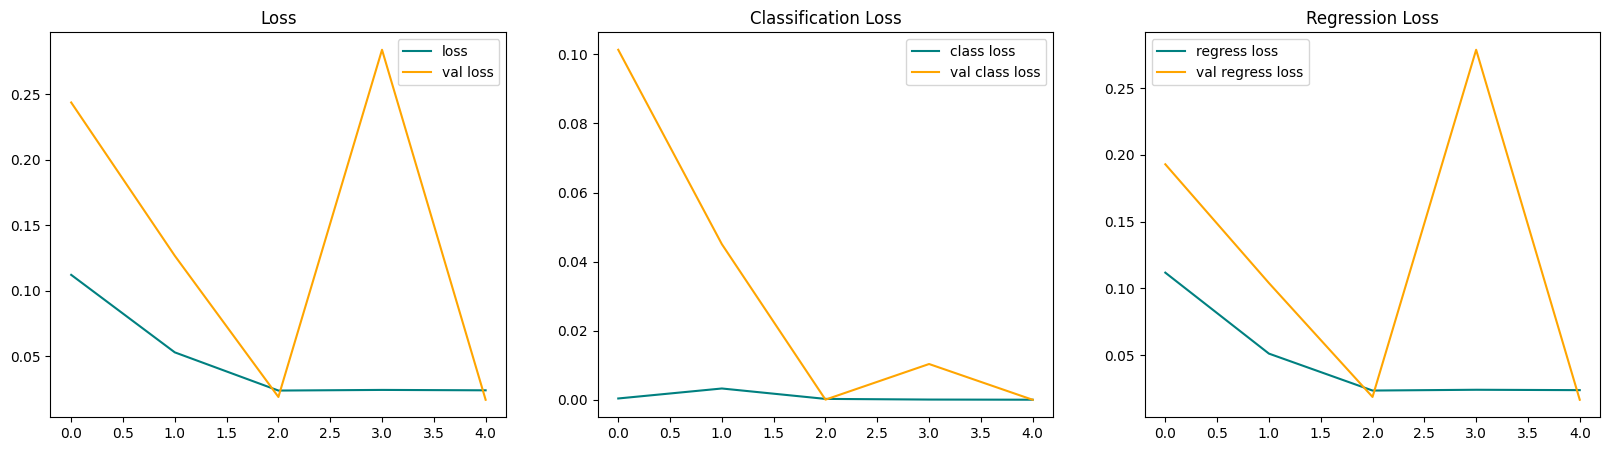

In [37]:
# checking the performance of the model
# hist.history

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [50]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


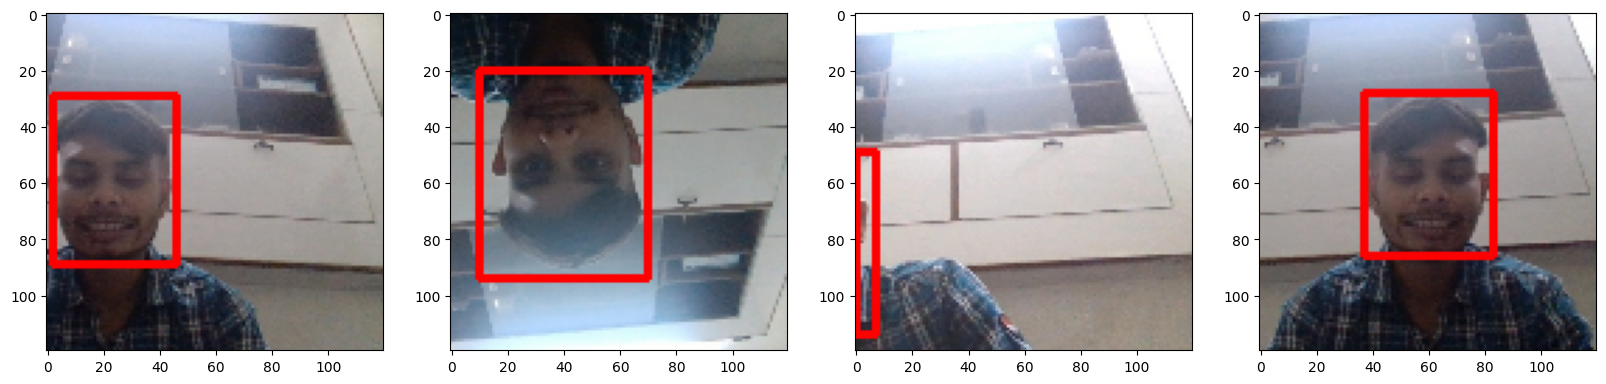

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_image = sample_image.copy() 
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)



In [52]:
from tensorflow.keras.models import load_model
facetracker.save('facetrack.h5', include_optimizer=True)
facetracker = load_model('facetracker.h5')

In [8]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5')
#facetracker = load_model('my_model.keras')


In [ ]:
cap=cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    plt.pause(0.01)  # Small pause to allow display update
    plt.clf()  # Clear figure to avoid multiple stacked images    
    # Ask for user input to stop
    stop = input("Press 'q' then Enter to quit: ")
    if stop.lower() == 'q':
        break
cap.release()


In [ ]:

cap.release()

In [ ]:
pip install keyboard
